In [23]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier


In [24]:
raw_df = pd.read_csv(r"/media/bavinhnguyen2704/New Volume/B2_usth/ML_2/Final/Data.csv")
df = pd.read_csv(r"/media/bavinhnguyen2704/New Volume/B2_usth/ML_2/Final/Data_remake.csv")

/tmp/ipykernel_21140/1637188805.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/media/bavinhnguyen2704/New Volume/B2_usth/ML_2/Final/Data_remake.csv")


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37962 entries, 0 to 37961
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SalesOrderID          37962 non-null  int64 
 1   Order_Date            37962 non-null  object
 2   LineTotal             37962 non-null  object
 3   CustomerID            37962 non-null  int64 
 4   Customer_full_name    37962 non-null  object
 5   Title                 33 non-null     object
 6   Status                37962 non-null  object
 7   City                  37962 non-null  object
 8   State_Province        37962 non-null  object
 9   Country_Region        37962 non-null  object
 10  ProductID             37962 non-null  int64 
 11  OrderQty              37962 non-null  int64 
 12  UnitPrice             37962 non-null  object
 13  ProductSubcategoryID  37962 non-null  int64 
 14  Product_Subcategory   37962 non-null  object
 15  ProductCategoryID     37962 non-null

In [22]:
df.shape()

TypeError: 'tuple' object is not callable

### First datatype transformation

In [6]:
df['UnitPrice'] = raw_df['UnitPrice']

df['LineTotal'] = df['LineTotal'].str.replace('.', '', regex= False)
df['LineTotal'] = df['LineTotal'].astype('float')
df['LineTotal'] = df.apply(lambda row: row['LineTotal'] if row['LineTotal'] == 0 else row['UnitPrice'] * row['OrderQty'], axis= 1)

### Fixing and filling null value of column 'Title'

In [7]:
df['Title'] = df['Title'].replace('Ms', 'Ms.')

list_of_title = df[df['Title'].notnull()]['Title'].unique()
df['Title'] = df['Title'].apply(lambda x: random.choice(list_of_title) if pd.isna(x) else x)


### Adding column 'Gender'

In [8]:
def turn_title_into_gender(data, title_column, gender_column):
    data[gender_column] = data[title_column].apply(lambda x: 'Male' if x in ['Mr.', 'Sr.'] else 'Female' if x in ['Ms.', 'Mrs.'] else None)

In [9]:
turn_title_into_gender(df, 'Title', 'Gender')
df['Gender'].value_counts()
df['Gender'].count()

37962

### Calculate range of using time

In [10]:
# Transform datatype to 'datetime'
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format= '%m/%d/%Y')

#Range of time in data:
print(f"Range of time: {df['Order_Date'].min()} - {df['Order_Date'].max()}")



Range of time: 2011-05-31 00:00:00 - 2014-06-30 00:00:00


In [11]:
df['Range_time'] = df['Order_Date'].apply(lambda x: df['Order_Date'].max() - x )

In [12]:
list_customer = df['CustomerID'].unique()
dic_RangeTime = {}
for each_cus in list_customer:
    max_rangetime_for_each_cus = (df[df['CustomerID'] == each_cus]['Range_time'].max())
    dic_RangeTime[each_cus] = max_rangetime_for_each_cus


In [13]:
range_time_table = pd.DataFrame(list(dic_RangeTime.items()), columns= ['CustomerID', 'Max_RangeTime'])
range_time_table.to_csv('Range_Time_table.csv')
# range_time_table['Max_RangeTime'] = range_time_table['Max_RangeTime'].astype(float)

### Define type of Customers

<h4 style="color: red;"> Distinguish type 2 and type 3 </h4>

In [14]:
table_group = df.groupby('CustomerID')[['LineTotal', 'OrderQty']].sum().reset_index()
table_group = pd.merge(table_group, range_time_table, on= 'CustomerID', how= 'inner' )

# Set condition for distinction
table_group['80% LineTotal'] = table_group['LineTotal'].quantile(0.8) 
table_group['80% OrderQty'] = table_group['OrderQty'].quantile(0.8)
table_group['80% RangeTime'] = table_group['Max_RangeTime'].quantile(0.8)

# Distinguish
table_group['Type'] = table_group.apply(lambda row: 2 if row['LineTotal'] < row['80% LineTotal'] 
                                        and row['OrderQty'] < row['80% OrderQty'] 
                                        and row['Max_RangeTime'] < row['80% RangeTime']
                                        else 3, axis= 1)
table_group

,CustomerID,LineTotal,OrderQty,Max_RangeTime,80% LineTotal,80% OrderQty,80% RangeTime,Type
0,11000,5875.01,8,1105 days,2319.99,5.0,671 days,3
1,11001,3477.95,11,1109 days,2319.99,5.0,671 days,3
2,11002,5784.06,4,1117 days,2319.99,5.0,671 days,3
3,11003,5795.34,9,1126 days,2319.99,5.0,671 days,3
4,11004,56.97,6,1101 days,2319.99,5.0,671 days,3
...,...,...,...,...,...,...,...,...
9773,20773,30.97,2,52 days,2319.99,5.0,671 days,2
9774,20774,14.98,3,115 days,2319.99,5.0,671 days,2
9775,20775,0.00,1,16 days,2319.99,5.0,671 days,2
9776,20776,22.93,3,255 days,2319.99,5.0,671 days,2


### Ploting data distribution

In [15]:
plot_data = table_group.groupby('Type')['LineTotal'].sum().reset_index(name = 'Sum')
plot_data = table_group.groupby('Type')['OrderQty'].sum().reset_index(name = 'Sum')
# plot_data = table_group.groupby('Type')['Type'].count().reset_index(name = 'Count')
# plot_data['Percent'] = plot_data['Count'] / plot_data['Count'].sum()
# plot_data['Percent'] = plot_data['Count'] / plot_data['Count'].sum()
plot_data

,Type,Sum
0,2,13679
1,3,24283


In [16]:
# plt.figure(figsize=(8, 6))
# plt.ylabel('Count of customer')

# plt.xlabel('Type of customer')
# Tạo dữ liệu mẫu
# labels = ['Type 2', 'Type 3']
# sizes = plot_data['Percent']  # Tỷ lệ phần trăm của từng danh mục
# colors = ['gold', 'yellowgreen']  # Màu sắc cho từng phần
# colors = ['lightcoral', 'lightskyblue']  # Màu sắc cho từng phần
# explode = (0.1, 0)  # Tạo hiệu ứng nổ cho phần đầu tiên (Category A)

# # Vẽ biểu đồ tròn
# plt.figure(figsize=(8, 8))
# plt.title('Number of each customer type')

# plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
#         shadow=True, startangle=140)
# plt.show()

/tmp/ipykernel_21140/441619910.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Type', y='Sum', data=plot_data, palette= 'bright')


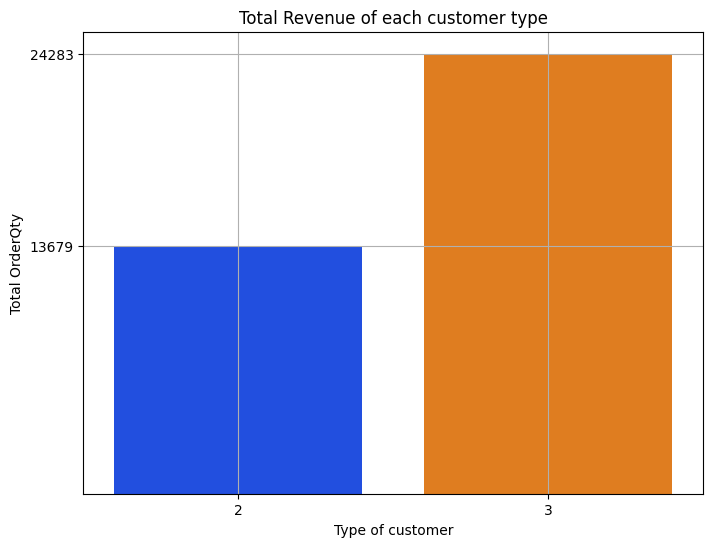

In [17]:
plt.figure(figsize=(8, 6))
# plt.title('Number of each customer type')
plt.title('Total Revenue of each customer type')
# plt.ylabel('Count of customer')
plt.ylabel('Total OrderQty')
plt.yticks(plot_data['Sum'])
plt.xlabel('Type of customer')
# sns.barplot(x='Type', y='Sum', data=plot_data, palette= 'viridis')
sns.barplot(x='Type', y='Sum', data=plot_data, palette= 'bright')

plt.grid()

plt.show()

### Intercept table

In [18]:
status_group = df.groupby(['CustomerID', 'Status'])['Status'].size().reset_index(name= 'Count_status')
status_group

,CustomerID,Status,Count_status
0,11000,Bought,6
1,11000,Viewed,2
2,11001,Bought,5
3,11001,Viewed,6
4,11002,Bought,2
...,...,...,...
16667,20774,Bought,2
16668,20774,Viewed,1
16669,20775,Viewed,1
16670,20776,Bought,3


In [19]:
table_customer = table_group.drop(columns= ['80% LineTotal', '80% OrderQty', '80% RangeTime'])
table_customer['Title'] = df['Title']
table_customer['Gender'] = df['Gender']
table_customer['City'] = df['City']
table_customer['State_Province'] = df['State_Province']
table_customer['Country_Region'] = df['Country_Region']
table_customer['Max_RangeTime'] = table_customer['Max_RangeTime'] / np.timedelta64(1, 'D')
table_customer = pd.merge(table_customer, status_group, on= 'CustomerID', how= 'inner')
table_customer

,CustomerID,LineTotal,OrderQty,Max_RangeTime,Type,Title,Gender,City,State_Province,Country_Region,Status,Count_status
0,11000,5875.01,8,1105.0,3,Sr.,Male,Colma,California,United States,Bought,6
1,11000,5875.01,8,1105.0,3,Sr.,Male,Colma,California,United States,Viewed,2
2,11001,3477.95,11,1109.0,3,Ms.,Female,Oak Bay,British Columbia,Canada,Bought,5
3,11001,3477.95,11,1109.0,3,Ms.,Female,Oak Bay,British Columbia,Canada,Viewed,6
4,11002,5784.06,4,1117.0,3,Mr.,Male,North Ryde,New South Wales,Australia,Bought,2
...,...,...,...,...,...,...,...,...,...,...,...,...
16667,20774,14.98,3,115.0,2,Sr.,Male,Los Angeles,California,United States,Bought,2
16668,20774,14.98,3,115.0,2,Sr.,Male,Los Angeles,California,United States,Viewed,1
16669,20775,0.00,1,16.0,2,Mrs.,Female,Los Angeles,California,United States,Viewed,1
16670,20776,22.93,3,255.0,2,Mrs.,Female,Los Angeles,California,United States,Bought,3


In [ ]:
labling_customer = LabelEncoder()
table_customer['Title_index'] = labling_customer.fit_transform(table_customer['Title'])
table_customer['Gender_index'] = labling_customer.fit_transform(table_customer['Title'])
table_customer['City_index'] = labling_customer.fit_transform(table_customer['Title'])
table_customer['State_Province_index'] = labling_customer.fit_transform(table_customer['Title'])
table_customer['Country_Region_index'] = labling_customer.fit_transform(table_customer['Title'])
table_customer['Status_index'] = labling_customer.fit_transform(table_customer['Status'])

table_customer = table_customer.drop(columns=['Title', 'Gender', 'City', 'State_Province', 'Country_Region', 'Status'])
table_customer

,CustomerID,LineTotal,OrderQty,Max_RangeTime,Type,Count_status,Title_index,Gender_index,City_index,State_Province_index,Country_Region_index,Status_index
0,11000,5875.01,8,1105.0,3,6,0,0,0,0,0,0
1,11000,5875.01,8,1105.0,3,2,0,0,0,0,0,1
2,11001,3477.95,11,1109.0,3,5,3,3,3,3,3,0
3,11001,3477.95,11,1109.0,3,6,3,3,3,3,3,1
4,11002,5784.06,4,1117.0,3,2,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
16667,20774,14.98,3,115.0,2,2,0,0,0,0,0,0
16668,20774,14.98,3,115.0,2,1,0,0,0,0,0,1
16669,20775,0.00,1,16.0,2,1,0,0,0,0,0,1
16670,20776,22.93,3,255.0,2,3,2,2,2,2,2,0


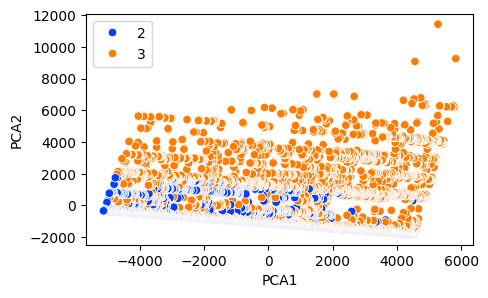

In [ ]:
pca = PCA(n_components=2, random_state = 27)
pca_dict = {"PCA1": [], "PCA2": []}
for pair in pca.fit_transform(table_customer.drop(columns=['Type'])):
    pca_dict["PCA1"].append(pair[0])
    pca_dict["PCA2"].append(pair[1])

new_df_pca = pd.DataFrame(pca_dict)
new_df_pca['Type'] = table_customer['Type']
plt.figure(figsize=[5,3])
sns.scatterplot(data= new_df_pca, x = 'PCA1', y = 'PCA2', hue= 'Type', palette = 'bright')
plt.legend()
plt.show()


<h4 style = "color: red;"> Distinguish type 1 or type in [2,3] </h4>

In [ ]:
# ID_input = int(input("Enter your ID: "))
def return_type(data, ID_input):
    for i, ID in enumerate(data['CustomerID']):
        if ID_input == ID:
            return ID_input, int(data.loc[i, 'Type'])
    return ID_input, 1

### General table of product

In [ ]:
table_of_product = df.groupby('ProductID')['OrderQty'].sum().reset_index()
table_of_product = pd.merge(table_of_product, df[['ProductID', 'ProductSubcategoryID', 'ProductCategoryID', 'Product_Subcategory', 'Product_Category']], on= 'ProductID', how= 'left')
table_of_product = table_of_product.drop_duplicates()
table_of_product = table_of_product.sort_values(by= 'ProductCategoryID', ascending= True)
# len(table_of_product)
table_of_product

,ProductID,OrderQty,ProductSubcategoryID,ProductCategoryID,Product_Subcategory,Product_Category
35467,956,69,3,1,Touring Bikes,Bikes
35788,966,86,3,1,Touring Bikes,Bikes
35770,965,18,3,1,Touring Bikes,Bikes
35750,964,20,3,1,Touring Bikes,Bikes
35730,963,20,3,1,Touring Bikes,Bikes
...,...,...,...,...,...,...
22813,877,607,29,4,Cleaners,Accessories
22568,876,245,26,4,Bike Racks,Accessories
20241,873,1952,37,4,Tires and Tubes,Accessories
19517,872,724,28,4,Bottles and Cages,Accessories


In [ ]:
print(table_of_product.groupby('Product_Category')['Product_Subcategory'].count())
test = table_of_product[['Product_Category', 'Product_Subcategory']].drop_duplicates()
print(test.groupby('Product_Category')['Product_Subcategory'].count())
print(test)
len(test.loc[test['Product_Category'] == 'Bikes']['Product_Subcategory'].unique())


Product_Category
Accessories    22
Bikes          88
Clothing       20
Name: Product_Subcategory, dtype: int64
Product_Category
Accessories    8
Bikes          3
Clothing       6
Name: Product_Subcategory, dtype: int64
      Product_Category Product_Subcategory
35467            Bikes       Touring Bikes
13149            Bikes          Road Bikes
37464            Bikes      Mountain Bikes
14186         Clothing               Vests
5289          Clothing             Jerseys
14553         Clothing              Shorts
13899         Clothing              Gloves
22193         Clothing               Socks
3922          Clothing                Caps
15364      Accessories   Bottles and Cages
0          Accessories             Helmets
27062      Accessories     Tires and Tubes
25546      Accessories     Hydration Packs
25382      Accessories         Bike Stands
23420      Accessories             Fenders
22813      Accessories            Cleaners
22568      Accessories          Bike Racks


3

<h4 style= "color: red;"> Type 1 </h4>

In [ ]:
type_1 = 24

#Find number of product for showing of each Subcategory
def Find_number_product_for_each_subcategory(data, total_recommend_number_for_type, ProductCategoryID_input):
    proportion = 1 / len(data.loc[data['ProductCategoryID'] == ProductCategoryID_input]['ProductSubcategoryID'].unique())
    number = round(total_recommend_number_for_type * proportion)
    return number

#Find list of product for showing of each Subcategory
def list_product_recommend(data, ProductCategoryID_input, ProductSubcategoryID_input, total_recommend_number_for_type):
    product_table = data.loc[data['Product_Subcategory'] == ProductSubcategoryID_input]
    product_table = product_table.sort_values(by = 'OrderQty', ascending = False)
    number_product_return = Find_number_product_for_each_subcategory(data, total_recommend_number_for_type, ProductCategoryID_input )
    return list(product_table.head(number_product_return)['ProductID'])

#Recommend list 
def RecommedBasedOnProduct(data, ProductCategoryID_input, total_recommend_number_for_type):
    table_recommend = data.loc[data['ProductCategoryID'] == ProductCategoryID_input]
    list_output = {}
    for each_ProductSubcategoryID in table_recommend['Product_Subcategory'].unique():
        table_output = list_product_recommend(table_recommend, ProductCategoryID_input, each_ProductSubcategoryID, total_recommend_number_for_type)
        # list_output[each_ProductSubcategoryID] = table_output.reset_index().drop(columns = ['index'])
        list_output[each_ProductSubcategoryID] = table_output
    return list_output

In [ ]:
def mofified(dict):
    max = len(list(dict.values())[0])
    for each_key in dict.keys():
        if len(dict[each_key]) > max:
            max = len(dict[each_key])
    for each_key in dict.keys():
        if len(dict[each_key]) < max:
            dict[each_key].append(None)
    return dict

In [ ]:
final_recommend_for_type1 = RecommedBasedOnProduct(table_of_product, 3, type_1)
final_recommend_for_type1

dic_table_type1 = []
for subcategory, product_ids in final_recommend_for_type1.items():
    for productid in product_ids:
        dic_table_type1.append({'ProductID': productid, 'Product_Subcategory': subcategory})
table_type1= pd.DataFrame(dic_table_type1)
table_type1

,ProductID,Product_Subcategory
0,865,Vests
1,866,Vests
2,864,Vests
3,715,Jerseys
4,713,Jerseys
5,714,Jerseys
6,869,Shorts
7,868,Shorts
8,867,Shorts
9,858,Gloves


#### Prepare data for type 2 and 3

In [ ]:
df = pd.merge(df, table_group[['CustomerID', 'Type']], on= 'CustomerID')

In [ ]:
# print("Row with duplicated: ")
# print(df[df.duplicated()])
# df = df.drop_duplicates()
# print("After remove duplicates: ")
# df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37962 entries, 0 to 37961
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype          
---  ------                --------------  -----          
 0   SalesOrderID          37962 non-null  int64          
 1   Order_Date            37962 non-null  datetime64[ns] 
 2   LineTotal             37962 non-null  float64        
 3   CustomerID            37962 non-null  int64          
 4   Customer_full_name    37962 non-null  object         
 5   Title                 37962 non-null  object         
 6   Status                37962 non-null  object         
 7   City                  37962 non-null  object         
 8   State_Province        37962 non-null  object         
 9   Country_Region        37962 non-null  object         
 10  ProductID             37962 non-null  int64          
 11  OrderQty              37962 non-null  int64          
 12  UnitPrice             37962 non-null  float64        
 13  P

### Intercept function

In [ ]:
#Find number of product for showing of each Category
def Find_number_product_for_each_category(data, total_recommend_number_for_type, customerID_input):
    proportion = 1 / len(data.loc[data['CustomerID'] == customerID_input]['ProductCategoryID'].unique())
    number = round(total_recommend_number_for_type * proportion)
    return number

#Recommend
def half_recommend_basedon_history_purchase(general_data, product_data, CustomerID_input, total_recommend_number_for_type):
    table_history_act = general_data.loc[general_data['CustomerID'] == CustomerID_input]
    list_recommend = []
    for each_category in table_history_act['ProductCategoryID'].unique():
        recommend = RecommedBasedOnProduct(product_data, each_category, Find_number_product_for_each_category(general_data, total_recommend_number_for_type, CustomerID_input ))
        list_recommend.append(recommend)
    return list_recommend

In [ ]:
# Evaluate Difference
def find_number_drop(table_1, table_2):
    return min(len(table_1), len(table_2))
    
def drop_balance(table_1, table_2):
    drop_length = find_number_drop(table_1, table_2)
    
    # Drop rows to balance the tables
    if len(table_1) > len(table_2):
        table_1 = table_1.iloc[:drop_length]
    elif len(table_1) < len(table_2):
        table_2 = table_2.iloc[:drop_length]
    
    return table_1, table_2

def evaluate_difference(table_1, table_2):
    count = 0
    for i in range(len(table_1)):
        for j in range(len(table_2)):
            if table_1.iloc[i].equals(table_2.iloc[j]):
                count += 1
    return (count / len(table_1)) * 100

#### Recommendations 

In [ ]:
def define_purchased_info_for_each_cluster(original_data, data_customer, cluster):
    table_cluster = data_customer.loc[data_customer['Cluster'] == cluster]
    table_order_cluster = original_data.loc[original_data['CustomerID'].isin(table_cluster['CustomerID'])]
    # table_product_count_cluster = table_order_cluster.groupby(['CustomerID', 'ProductID']).size().reset_index(name = 'Count_product')
    table_product_count_cluster = table_order_cluster.groupby(['ProductID']).size().reset_index(name = 'Count_product')
    # table_most_product_cluster = table_product_count_cluster.loc[table_product_count_cluster.groupby('CustomerID')['Count_product'].idxmax()]
    # return table_most_product_cluster.sort_values(by = 'Count_product', ascending = False)
    return table_product_count_cluster.sort_values(by = 'Count_product', ascending = False)

def define_cluster_of_customer(table_customer, CustomerID_input):
    cluster = table_customer.loc[table_customer['CustomerID'] == CustomerID_input]['Cluster']
    return int(cluster.mode())

def recommend_product_basedon_cluster(general_data, CustomerID_input, total_recommendations):
    table_purchase_in_same_cluster = define_purchased_info_for_each_cluster(df, general_data , define_cluster_of_customer(general_data, CustomerID_input))
    # return table_purchase_in_same_cluster.loc[table_purchase_in_same_cluster['CustomerID'] != CustomerID_input]['ProductID'].head(total_recommendations)
    return table_purchase_in_same_cluster['ProductID'].head(total_recommendations)


<h4 style= "color: red;"> Type 3 </h4>

In [ ]:
table_for_type3 = df.loc[df['Type'] == 3]
table_for_type3

,SalesOrderID,Order_Date,LineTotal,CustomerID,Customer_full_name,Title,Status,City,State_Province,Country_Region,ProductID,OrderQty,UnitPrice,ProductSubcategoryID,Product_Subcategory,ProductCategoryID,Product_Category,Gender,Range_time,Type
0,43700,2011-05-31,0.00,14501,Bryan J Gray,Mr.,Viewed,Colma,California,United States,767,1,699.0982,2,Road Bikes,1,Bikes,Male,1126 days,3
1,43701,2011-05-31,3399.99,11003,Jenna W Young,Sr.,Bought,Oak Bay,British Columbia,Canada,773,1,3399.9900,1,Mountain Bikes,1,Bikes,Male,1126 days,3
2,43703,2011-06-01,3578.27,16624,Nichole A Goel,Mrs.,Bought,North Ryde,New South Wales,Australia,749,1,3578.2700,2,Road Bikes,1,Bikes,Female,1125 days,3
3,43704,2011-06-01,3374.99,11005,Joe Madan,Ms.,Bought,Brisbane,Queensland,Australia,778,1,3374.9900,1,Mountain Bikes,1,Bikes,Female,1125 days,3
4,43705,2011-06-01,0.00,11011,Joe D Rana,Mrs.,Viewed,Warrnambool,Victoria,Australia,771,1,3399.9900,1,Mountain Bikes,1,Bikes,Female,1125 days,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37957,75122,2014-06-30,0.00,15868,José J Perez,Ms.,Viewed,Corvallis,Oregon,United States,878,1,21.9800,30,Fenders,4,Accessories,Female,0 days,3
37958,75122,2014-06-30,8.99,15868,José J Perez,Mrs.,Bought,Corvallis,Oregon,United States,712,1,8.9900,19,Caps,3,Clothing,Female,0 days,3
37959,75123,2014-06-30,0.00,18759,Joshua Johnson,Mrs.,Viewed,Erlangen,Bayern,Germany,878,1,21.9800,30,Fenders,4,Accessories,Female,0 days,3
37960,75123,2014-06-30,0.00,18759,Joshua Johnson,Ms.,Viewed,Erlangen,Bayern,Germany,879,1,159.0000,27,Bike Stands,4,Accessories,Female,0 days,3


<h5 style = "color: blue"> 50% </h5> 

In [ ]:
type_3_first50 = 12

half_final_recommend_for_type3 = half_recommend_basedon_history_purchase(table_for_type3, table_of_product, 14501, type_3_first50)
dic_table_type3_first50 = []
for catergory in half_final_recommend_for_type3:
    for subcategory, product_ids in catergory.items():
        for productid in product_ids:
            dic_table_type3_first50.append({'ProductID': productid, 'Product_Subcategory': subcategory})
table_type3_first50 = pd.DataFrame(dic_table_type3_first50)
table_type3_first50

,ProductID,Product_Subcategory
0,954,Touring Bikes
1,966,Touring Bikes
2,955,Touring Bikes
3,957,Touring Bikes
4,749,Road Bikes
5,751,Road Bikes
6,752,Road Bikes
7,753,Road Bikes
8,784,Mountain Bikes
9,783,Mountain Bikes


<h5 style = "color: blue"> 50% </h5> 


In [ ]:
table_customer_type3 = table_group.drop(columns= ['80% LineTotal', '80% OrderQty', '80% RangeTime']).loc[table_group['Type'] == 3]
table_customer_type3['Title'] = df['Title']
table_customer_type3['Gender'] = df['Gender']
table_customer_type3['City'] = df['City']
table_customer_type3['State_Province'] = df['State_Province']
table_customer_type3['Country_Region'] = df['Country_Region']
table_customer_type3['Max_RangeTime'] = table_customer_type3['Max_RangeTime'] / np.timedelta64(1, 'D')
table_customer_type3 = pd.merge(table_customer_type3, status_group, on= 'CustomerID', how= 'inner')
table_customer_type3

,CustomerID,LineTotal,OrderQty,Max_RangeTime,Type,Title,Gender,City,State_Province,Country_Region,Status,Count_status
0,11000,5875.01,8,1105.0,3,Mr.,Male,Colma,California,United States,Bought,6
1,11000,5875.01,8,1105.0,3,Mr.,Male,Colma,California,United States,Viewed,2
2,11001,3477.95,11,1109.0,3,Sr.,Male,Oak Bay,British Columbia,Canada,Bought,5
3,11001,3477.95,11,1109.0,3,Sr.,Male,Oak Bay,British Columbia,Canada,Viewed,6
4,11002,5784.06,4,1117.0,3,Mrs.,Female,North Ryde,New South Wales,Australia,Bought,2
...,...,...,...,...,...,...,...,...,...,...,...,...
8180,20745,24.49,5,260.0,3,Mrs.,Female,Cliffside,British Columbia,Canada,Viewed,4
8181,20746,79.97,5,306.0,3,Ms.,Female,Cliffside,British Columbia,Canada,Bought,3
8182,20746,79.97,5,306.0,3,Ms.,Female,Cliffside,British Columbia,Canada,Viewed,2
8183,20759,82.96,8,222.0,3,Sr.,Male,Metz,Moselle,France,Bought,4


In [ ]:
labling_type3 = LabelEncoder()
table_customer_type3['Title_index'] = labling_type3.fit_transform(table_customer_type3['Title'])
table_customer_type3['Gender_index'] = labling_type3.fit_transform(table_customer_type3['Title'])
table_customer_type3['City_index'] = labling_type3.fit_transform(table_customer_type3['Title'])
table_customer_type3['State_Province_index'] = labling_type3.fit_transform(table_customer_type3['Title'])
table_customer_type3['Country_Region_index'] = labling_type3.fit_transform(table_customer_type3['Title'])
table_customer_type3['Status_index'] = labling_type3.fit_transform(table_customer_type3['Status'])

table_customer_type3 = table_customer_type3.drop(columns=['Title', 'Gender', 'City', 'State_Province', 'Country_Region', 'Status'])


##### Find best k for clustering

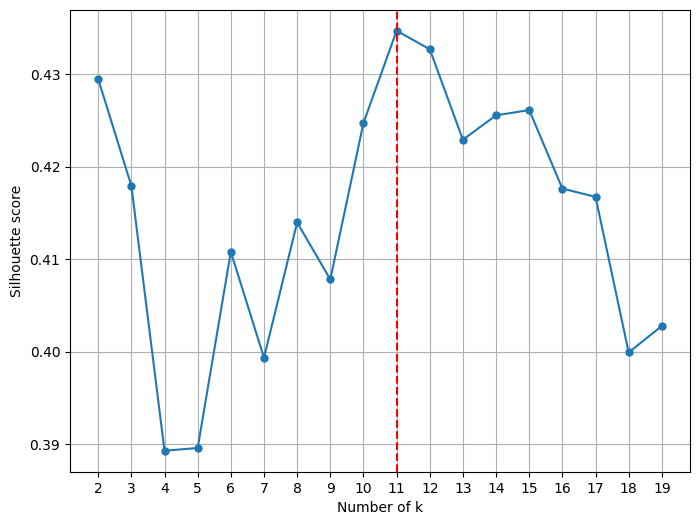

In [ ]:
# Silhouette method
si_scr = []
for i in range(2, 20):
    kmeans_silhouette = KMeans(n_clusters= i, random_state= 27)
    kmeans_silhouette.fit(table_customer_type3)
    score = silhouette_score(table_customer_type3, kmeans_silhouette.labels_)
    si_scr.append(score)

plt.figure(figsize= [8,6])
plt.plot(range(2,20), si_scr, '.-', markersize = 10)
plt.xticks(range(2, 20))
# plt.yticks(si_scr)
plt.xlabel('Number of k')
plt.ylabel('Silhouette score')
plt.grid()
plt.axvline(x= si_scr.index(max(si_scr)) + 2, color = 'r', linestyle = '--')
plt.show()

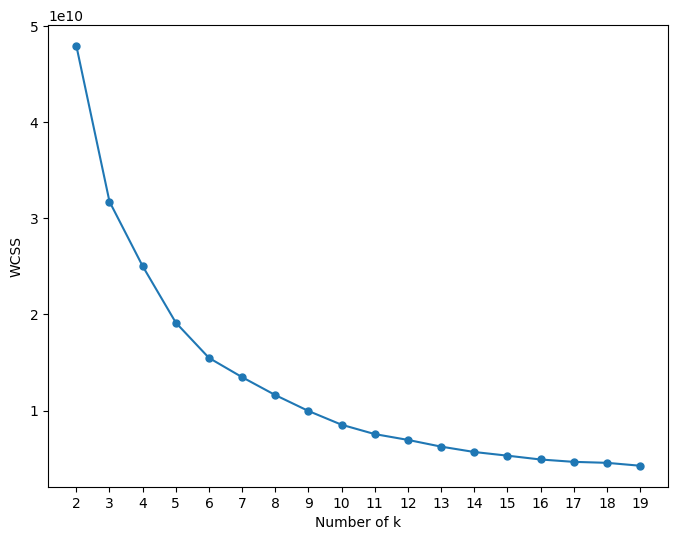

In [ ]:
# Elbow method ver 1
wcss = []
for i in range(2, 20):
    kmeans_elbow = KMeans(n_clusters= i, random_state= 27)
    kmeans_elbow.fit(table_customer_type3)
    wcss.append(kmeans_elbow.inertia_)

plt.figure(figsize= [8,6])
plt.plot(range(2,20), wcss, '.-', markersize = 10)
plt.xticks(range(2, 20))
plt.xlabel('Number of k')
plt.ylabel('WCSS')
# plt.axvline(x= wcss.index(max(wcss)) + 2, color = 'r', linestyle = '--')
plt.show()

In [ ]:
# Elbow method ver 2
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(table_customer_type3)

df_final_scaled = pd.DataFrame(scaled, columns=table_customer_type3.columns)
df_final_scaled = df_final_scaled.drop(columns=['CustomerID', 'Type'])

In [ ]:
# from yellowbrick.cluster import KElbowVisualizer
# elbow = KElbowVisualizer(KMeans(random_state=27), k=20)
# elbow.fit(df_final_scaled)
# elbow.show()

In [ ]:
# # Dendrogram method
# from sklearn.preprocessing import normalize
# data_scaled = normalize(table_customer_type3) #normalize data
# data_scaled = pd.DataFrame(data_scaled, columns=table_customer_type3.columns)

# import scipy.cluster.hierarchy as shc
# plt.title("Dendrograms")
# dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))
# plt.axhline(y=4, color='green', linestyle='--')

### Define Cluster of type 3

In [ ]:
kmean_final = KMeans(n_clusters= 7, random_state= 27)
kmean_final.fit(table_customer_type3)
table_customer_type3['Cluster'] = kmean_final.predict(table_customer_type3)
table_customer_type3['Cluster'].value_counts()

Cluster
5    1408
0    1336
3    1291
6    1276
1    1042
2     941
4     891
Name: count, dtype: int64

In [ ]:
type_3_last50 = 12
table_type3_last50 = pd.merge(table_of_product, pd.DataFrame(recommend_product_basedon_cluster(table_customer_type3, 13468, type_3_last50), columns= ['ProductID']).reset_index().drop(columns= ['index'])
                        , on= 'ProductID', how= 'inner').drop(columns= ['OrderQty','ProductCategoryID', 'ProductSubcategoryID', 'Product_Category'])


table_recommendation_final_for_type3 = pd.concat([table_type3_first50, table_type3_last50], axis= 0).reset_index().drop(columns= ['index']).drop_duplicates()
table_recommendation_final_for_type3


/tmp/ipykernel_15175/3786078991.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(cluster.mode())


,ProductID,Product_Subcategory
0,954,Touring Bikes
1,966,Touring Bikes
2,955,Touring Bikes
3,957,Touring Bikes
4,749,Road Bikes
5,751,Road Bikes
6,752,Road Bikes
7,753,Road Bikes
8,784,Mountain Bikes
9,783,Mountain Bikes


<h4 style= "color: red;"> Type 2 </h4>

In [ ]:
# table_for_type2
table_for_type2 = df.loc[df['Type'] == 2]
table_for_type2

,SalesOrderID,Order_Date,LineTotal,CustomerID,Customer_full_name,Title,Status,City,State_Province,Country_Region,ProductID,OrderQty,UnitPrice,ProductSubcategoryID,Product_Subcategory,ProductCategoryID,Product_Category,Gender,Range_time,Type
1966,47653,2012-08-29,782.99,20163,Phillip P Prasad,Sr.,Bought,Colombes,Hauts de Seine,France,761,1,782.9900,2,Road Bikes,1,Bikes,Male,670 days,2
1969,47733,2012-08-30,0.00,13461,Dalton C Powell,Mrs.,Viewed,Woodland Hills,California,United States,794,1,2181.5625,2,Road Bikes,1,Bikes,Female,669 days,2
1970,47734,2012-08-30,782.99,15333,Jillian Lopez,Mrs.,Bought,Beverly Hills,California,United States,765,1,782.9900,2,Road Bikes,1,Bikes,Female,669 days,2
1972,47737,2012-08-30,0.00,13018,Robyn C Alonso,Mrs.,Viewed,Chatou,Yveline,France,781,1,2071.4196,1,Mountain Bikes,1,Bikes,Female,669 days,2
1973,47740,2012-08-31,0.00,15337,Richard Morris,Mr.,Viewed,Vancouver,British Columbia,Canada,761,1,782.9900,2,Road Bikes,1,Bikes,Male,668 days,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37943,75117,2014-06-30,24.49,18178,Randy B Zheng,Sr.,Bought,Port Macquarie,New South Wales,Australia,860,1,24.4900,20,Gloves,3,Clothing,Male,0 days,2
37944,75118,2014-06-30,4.99,13671,Rodney I Moreno,Mrs.,Bought,Concord,California,United States,923,1,4.9900,37,Tires and Tubes,4,Accessories,Female,0 days,2
37945,75118,2014-06-30,0.00,13671,Rodney I Moreno,Ms.,Viewed,Concord,California,United States,873,1,2.2900,37,Tires and Tubes,4,Accessories,Female,0 days,2
37946,75118,2014-06-30,0.00,13671,Rodney I Moreno,Sr.,Viewed,Concord,California,United States,877,1,7.9500,29,Cleaners,4,Accessories,Male,0 days,2


<h5 style = "color: blue"> 50% </h5> 

In [ ]:
type_2_first50 = 12

half_final_recommend_for_type2 = half_recommend_basedon_history_purchase(table_for_type2, table_of_product, 20163, type_2_first50)
dic_table_type2_first50 = []
for catergory in half_final_recommend_for_type2:
    for subcategory, product_ids in catergory.items():
        for productid in product_ids:
            dic_table_type2_first50.append({'ProductID': productid, 'Product_Subcategory': subcategory})
table_type2_first50 = pd.DataFrame(dic_table_type2_first50)
table_type2_first50

,ProductID,Product_Subcategory
0,954,Touring Bikes
1,966,Touring Bikes
2,955,Touring Bikes
3,957,Touring Bikes
4,749,Road Bikes
5,751,Road Bikes
6,752,Road Bikes
7,753,Road Bikes
8,784,Mountain Bikes
9,783,Mountain Bikes


<h5 style = "color: blue"> 50% </h5> 

In [ ]:
table_customer_type2 = table_group.drop(columns= ['80% LineTotal', '80% OrderQty', '80% RangeTime']).loc[table_group['Type'] == 2]
table_customer_type2['Title'] = df['Title']
table_customer_type2['Gender'] = df['Gender']
table_customer_type2['City'] = df['City']
table_customer_type2['State_Province'] = df['State_Province']
table_customer_type2['Country_Region'] = df['Country_Region']
table_customer_type2['Max_RangeTime'] = table_customer_type2['Max_RangeTime'] / np.timedelta64(1, 'D')
table_customer_type2 = pd.merge(table_customer_type2, status_group, on= 'CustomerID', how= 'inner')
table_customer_type2

,CustomerID,LineTotal,OrderQty,Max_RangeTime,Type,Title,Gender,City,State_Province,Country_Region,Status,Count_status
0,11016,35.00,3,353.0,2,Mrs.,Female,Milton Keynes,England,United Kingdom,Bought,1
1,11016,35.00,3,353.0,2,Mrs.,Female,Milton Keynes,England,United Kingdom,Viewed,2
2,11020,0.00,2,395.0,2,Sr.,Male,South Melbourne,Victoria,Australia,Viewed,2
3,11022,0.00,2,373.0,2,Sr.,Male,Cincinnati,Ohio,United States,Viewed,2
4,11036,0.00,2,371.0,2,Sr.,Male,Beverly Hills,California,United States,Viewed,2
...,...,...,...,...,...,...,...,...,...,...,...,...
8482,20774,14.98,3,115.0,2,Mr.,Male,Los Angeles,California,United States,Bought,2
8483,20774,14.98,3,115.0,2,Mr.,Male,Los Angeles,California,United States,Viewed,1
8484,20775,0.00,1,16.0,2,Mr.,Male,Los Angeles,California,United States,Viewed,1
8485,20776,22.93,3,255.0,2,Ms.,Female,Los Angeles,California,United States,Bought,3


In [ ]:
labling_type2 = LabelEncoder()
table_customer_type2['Title_index'] = labling_type2.fit_transform(table_customer_type2['Title'])
table_customer_type2['Gender_index'] = labling_type2.fit_transform(table_customer_type2['Title'])
table_customer_type2['City_index'] = labling_type2.fit_transform(table_customer_type2['Title'])
table_customer_type2['State_Province_index'] = labling_type2.fit_transform(table_customer_type2['Title'])
table_customer_type2['Country_Region_index'] = labling_type2.fit_transform(table_customer_type2['Title'])
table_customer_type2['Status_index'] = labling_type2.fit_transform(table_customer_type2['Status'])

table_customer_type2 = table_customer_type2.drop(columns=['Title', 'Gender', 'City', 'State_Province', 'Country_Region', 'Status'])

### Define Cluster of type 2

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, random_state=27)

X_train = table_customer_type3.drop(columns=['Cluster'])
y_train = table_customer_type3['Cluster']

classifier.fit(X_train, y_train)
table_customer_type2['Cluster'] = classifier.predict(table_customer_type2)
table_customer_type2

,CustomerID,LineTotal,OrderQty,Max_RangeTime,Type,Count_status,Title_index,Gender_index,City_index,State_Province_index,Country_Region_index,Status_index,Cluster
0,11016,35.00,3,353.0,2,1,1,1,1,1,1,0,6
1,11016,35.00,3,353.0,2,2,1,1,1,1,1,1,6
2,11020,0.00,2,395.0,2,2,3,3,3,3,3,1,6
3,11022,0.00,2,373.0,2,2,3,3,3,3,3,1,6
4,11036,0.00,2,371.0,2,2,3,3,3,3,3,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8482,20774,14.98,3,115.0,2,2,0,0,0,0,0,0,1
8483,20774,14.98,3,115.0,2,1,0,0,0,0,0,1,1
8484,20775,0.00,1,16.0,2,1,0,0,0,0,0,1,1
8485,20776,22.93,3,255.0,2,3,2,2,2,2,2,0,1


In [ ]:
type_2_last50 = 12
table_type2_last50 = pd.merge(table_of_product, pd.DataFrame(recommend_product_basedon_cluster(table_customer_type2, 11016, type_2_last50), columns= ['ProductID']).reset_index().drop(columns= ['index'])
                        , on= 'ProductID', how= 'inner').drop(columns= ['OrderQty','ProductCategoryID', 'ProductSubcategoryID', 'Product_Category'])

table_type2_last50
# # table_recommendation_final_for_type2 = pd.concat([table_type2_first50, table_type2_last50], axis= 0).reset_index().drop(columns= ['index']).drop_duplicates()
# table_recommendation_final_for_type2 = pd.concat([table_type2_first50, table_type2_last50], axis= 0).reset_index().drop(columns= ['index'])

# table_recommendation_final_for_type2

/tmp/ipykernel_15175/3786078991.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(cluster.mode())


,ProductID,Product_Subcategory
0,712,Caps
1,870,Bottles and Cages
2,707,Helmets
3,708,Helmets
4,711,Helmets
5,921,Tires and Tubes
6,930,Tires and Tubes
7,878,Fenders
8,873,Tires and Tubes
9,871,Bottles and Cages


In [ ]:
with open('ID.txt', 'r') as ID_file:
    cusID, type = return_type(table_group, int(ID_file.read()))
    if type == 1:
        with open('Category.txt', 'r') as Category_file:
            dict_recommend_1 = RecommedBasedOnProduct(table_of_product, int(Category_file.read()), 20)
            dic_table_type1 = []
            for subcategory, product_ids in dict_recommend_1.items():
                for productid in product_ids:
                    dic_table_type1.append({'ProductID': productid, 'Product_Subcategory': subcategory})
            output_recommend = pd.DataFrame(dic_table_type1)
            Category_file.close()
    if type == 2:
        type_2_first50 = 12

        half_final_recommend_for_type2 = half_recommend_basedon_history_purchase(table_for_type2, table_of_product, cusID, type_2_first50)
        dic_table_type2_first50 = []
        for catergory in half_final_recommend_for_type2:
            for subcategory, product_ids in catergory.items():
                for productid in product_ids:
                    dic_table_type2_first50.append({'ProductID': productid, 'Product_Subcategory': subcategory})
        table_type2_first50 = pd.DataFrame(dic_table_type2_first50)

        type_2_last50 = 12
        table_type2_last50 = pd.merge(table_of_product, pd.DataFrame(recommend_product_basedon_cluster(table_customer_type2, 11016, type_2_last50), columns= ['ProductID']).reset_index().drop(columns= ['index'])
                        , on= 'ProductID', how= 'inner').drop(columns= ['OrderQty','ProductCategoryID', 'ProductSubcategoryID', 'Product_Category'])
        print("Type 2")
        table_type2_first50, table_type2_last50 = drop_balance(table_type2_first50, table_type2_last50)
        print("First 50%")
        print(table_type2_first50)
        print("Last 50%")
        print(table_type2_last50)
        print(f"\nSimilarity percent: {evaluate_difference(table_type2_first50, table_type2_last50)}")
        output_recommend = pd.concat([table_type2_first50, table_type2_last50], axis= 0).reset_index().drop(columns= ['index']).drop_duplicates()

    if type == 3:
        type_3_first50 = 12

        half_final_recommend_for_type3 = half_recommend_basedon_history_purchase(table_for_type3, table_of_product, 14501, type_3_first50)
        dic_table_type3_first50 = []
        for catergory in half_final_recommend_for_type3:
            for subcategory, product_ids in catergory.items():
                for productid in product_ids:
                    dic_table_type3_first50.append({'ProductID': productid, 'Product_Subcategory': subcategory})
        table_type3_first50 = pd.DataFrame(dic_table_type3_first50)

        type_3_last50 = 10
        table_type3_last50 = pd.merge(table_of_product, pd.DataFrame(recommend_product_basedon_cluster(table_customer_type3, 13468, type_3_last50), columns= ['ProductID']).reset_index().drop(columns= ['index'])
                        , on= 'ProductID', how= 'inner').drop(columns= ['OrderQty','ProductCategoryID', 'ProductSubcategoryID', 'Product_Category'])

        print("Type 3")
        table_type3_first50, table_type3_last50 = drop_balance(table_type3_first50, table_type3_last50)
        print("First 50%")
        print(table_type3_first50)
        print("Last 50%")
        print(table_type3_last50)
        print(f"\nSimilarity percent: {evaluate_difference(table_type3_first50, table_type3_last50)}")

        output_recommend = pd.concat([table_type3_first50, table_type3_last50], axis= 0).reset_index().drop(columns= ['index']).drop_duplicates()


output_recommend.to_csv('Output.csv')


Type 3
First 50%
   ProductID Product_Subcategory
0        954       Touring Bikes
1        966       Touring Bikes
2        955       Touring Bikes
3        957       Touring Bikes
4        749          Road Bikes
5        751          Road Bikes
6        752          Road Bikes
7        753          Road Bikes
8        784      Mountain Bikes
9        783      Mountain Bikes
Last 50%
   ProductID Product_Subcategory
0        712                Caps
1        870   Bottles and Cages
2        707             Helmets
3        708             Helmets
4        921     Tires and Tubes
5        922     Tires and Tubes
6        930     Tires and Tubes
7        878             Fenders
8        873     Tires and Tubes
9        871   Bottles and Cages

Similarity percent: 0.0


/tmp/ipykernel_15175/3786078991.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  return int(cluster.mode())
